In [1]:
import sys
import os
import matplotlib.pyplot as plt
import cv2

import numpy as np

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.data_processing.dataset_loader import CoastData
from src.data_processing.dataset_preprocessor import DatasetPreprocessor

In [2]:
# data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

predictions_path = {
    "binary": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_binary/")),
    "three_classes": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_2025/")),
    "four_classes": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_4_classes/")),
}

data = {
    "binary": {
        "images": os.listdir(os.path.join(predictions_path["binary"], "images")),
        "masks": os.listdir(os.path.join(predictions_path["binary"], "masks")),
        "predicted_mask": os.listdir(os.path.join(predictions_path["binary"], "predicted_mask")),
    },
}

sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]

print(data["binary"]["images"])

# Path of the test images organized by station
test_path = "images/test/"
test_images_path = {
    "agrelo": [],
    "arenaldentem": [],
    "cadiz": [],
    "cies": [],
    "samarador": [],
}

print(os.path.join(predictions_path["binary"], test_path))
print(len(os.listdir(os.path.join(predictions_path["binary"], test_path))))
binary_test_path = os.path.join(predictions_path["binary"], test_path)
for img_path in os.listdir(os.path.join(predictions_path["binary"], test_path)):
    
    if "agrelo" in img_path:
        test_images_path["agrelo"].append(img_path)
    elif "arenaldentem" in img_path:
        test_images_path["arenaldentem"].append(img_path)
    elif "cadiz" in img_path:
        test_images_path["cadiz"].append(img_path)
    elif "cies" in img_path:
        test_images_path["cies"].append(img_path)
    elif "samarador" in img_path:
        test_images_path["samarador"].append(img_path)

for station in sation_names:
    print(f"Station: {station}")
    print("length of test images path: ", len(test_images_path[station]))


['test', 'train', 'validation']
c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet_binary\images/test/
174
Station: agrelo
length of test images path:  25
Station: arenaldentem
length of test images path:  4
Station: cadiz
length of test images path:  95
Station: cies
length of test images path:  44
Station: samarador
length of test images path:  6


In [3]:
CLASS_COLORS = {
    'NoData': (0, 0, 0),        # (black)
    'Landwards': (139, 69, 19), # (brown)
    'Seawards': (0, 0, 255),    # (blue)
    'Shoreline': (0, 255, 0),   # (green)
    'Predicted_Shoreline': (255, 0, 0), # (red)
    'Coincidence': (255, 255, 0) # (yellow)
}

# Define a custom colormap for the mask
def apply_custom_colormap(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["NoData"]
    colored_mask[mask == 2] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 1] = CLASS_COLORS["Landwards"]
    colored_mask[mask == 3] = CLASS_COLORS["Shoreline"]

    return colored_mask

def crop_center(image, crop_size, start):
    """
    Crops the center of the image to the specified size.

    Parameters:
    image (np.array): The input image.
    crop_size (tuple): The desired crop size (width, height).

    Returns:
    np.array: The cropped image.
    """
    h, w = image.shape[:2]
    crop_w, crop_h = crop_size
    start_x, start_y = start

    end_x = start_x + crop_w
    end_y = start_y + crop_h

    return image[start_y:end_y, start_x:end_x]

def apply_masks(image, mask, predicted_mask, shoreline_pixel_mask, shoreline_pixel_predicted_mask):
    """
    Applies the shoreline masks to the image with alpha blending only where the masks are present.

    Parameters:
    image (np.array): The input image (H x W x 3).
    mask (np.array): The ground truth mask (unused here).
    predicted_mask (np.array): The predicted mask (unused here).
    shoreline_pixel_mask (int): The value representing the shoreline in the ground truth mask.
    shoreline_pixel_predicted_mask (int): The value representing the shoreline in the predicted mask.

    Returns:
    np.array: The image with overlayed masks.
    """
    # Copy original image
    overlay = image.copy()

    alpha = 0.6  # transparència

    green = np.array([0, 255, 0], dtype=np.uint8)     # Shoreline
    red = np.array([255, 0, 0], dtype=np.uint8)       # Predicted shoreline
    yellow = np.array([255, 255, 0], dtype=np.uint8)  # Coincidència

    # Crea màscares booleanes
    only_shoreline = (mask == shoreline_pixel_mask) & (predicted_mask != shoreline_pixel_predicted_mask)
    only_predicted = (mask != shoreline_pixel_mask) & (predicted_mask == shoreline_pixel_predicted_mask)
    both = (mask == shoreline_pixel_mask) & (predicted_mask == shoreline_pixel_predicted_mask)

    # Aplica el color corresponent amb alpha blending
    overlay[only_shoreline] = (
        alpha * green + (1 - alpha) * overlay[only_shoreline]
    ).astype(np.uint8)

    overlay[only_predicted] = (
        alpha * red + (1 - alpha) * overlay[only_predicted]
    ).astype(np.uint8)

    overlay[both] = (
        alpha * yellow + (1 - alpha) * overlay[both]
    ).astype(np.uint8)

    return overlay


# For the 3 classes

def find_shoreline(pred, land_pixel, sea_pixel):
    shoreline = np.zeros_like(pred)
    for i in range(pred.shape[0]):
        for j in range(1, pred.shape[1]):
            if pred[i, j] == land_pixel and pred[i, j-1] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i, j-1] == land_pixel:
                shoreline[i, j-1] = 1

    for j in range(pred.shape[1]):
        for i in range(1, pred.shape[0]):
            if pred[i, j] == land_pixel and pred[i-1, j] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i-1, j] == land_pixel:
                shoreline[i-1, j] = 1
            
    return shoreline

def find_largest_contour(shoreline_mask):
    # Trobar els contorns a la màscara de la línia de costa
    contours, _ = cv2.findContours(shoreline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None

    # Trobar el contorn més gran
    largest_contour = max(contours, key=len)

    return largest_contour

def transform_mask_to_shoreline2(pred_path, no_data=0, landward=75, seaward=150):
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    shoreline = find_shoreline(pred, landward, seaward)

    largest_contour = find_largest_contour(shoreline)

    if largest_contour is None:
        return None 

    # Crear una màscara per dibuixar el contorn més gran
    largest_shoreline = np.zeros_like(shoreline)
    cv2.drawContours(largest_shoreline, [largest_contour], -1, 1, thickness=cv2.FILLED)

    return largest_shoreline


def get_image(predictions_path, test_images_path, station, index, shoreline_pixel_mask, shoreline_pixel_predicted_mask, crop_size=(256, 256), three_classes=False):
    path_img = os.path.join(predictions_path, "images/test",test_images_path[station][index])
    # path_img = filtered_data[station]['train']['images'][0]
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read mask
    path_mask = os.path.join(predictions_path, "masks/test",test_images_path[station][index].replace("image.jpg", "mask.png"))
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)

    # Read predicted mask
    path_predicted_mask = os.path.join(predictions_path, "predicted_mask/test",test_images_path[station][index].replace("image.jpg", "mask.png"))
    if three_classes:
        predicted_mask = transform_mask_to_shoreline2(pred_path = path_predicted_mask, landward=1, seaward=2)
        # plt.imshow(predicted_mask)
        # plt.show()
    else:
        predicted_mask = cv2.imread(path_predicted_mask, cv2.IMREAD_GRAYSCALE)

    combined_image = apply_masks(img, mask, predicted_mask, shoreline_pixel_mask=shoreline_pixel_mask, shoreline_pixel_predicted_mask=shoreline_pixel_predicted_mask)

    # Crop image and mask
    combined_image = crop_center(combined_image, crop_size, config[station]['start'])

    return combined_image
    

config = {
    "agrelo": {
        "start": [230, 100],
    }, 
    "arenaldentem": {
        "start": [40, 0],
    },
    "cadiz": {
        "start": [120, 0],
    },
    "cies": {
        "start": [90, 0],
    },
    "samarador": {
        "start": [0, 0],
    }
}    

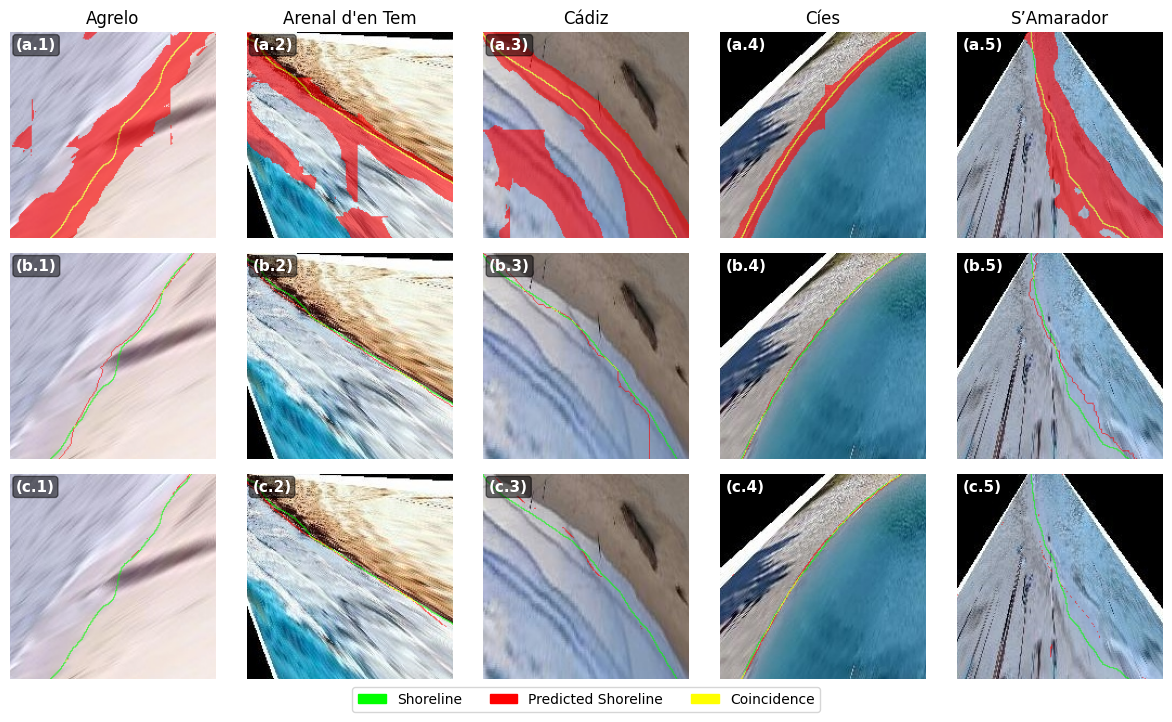

In [7]:

import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)', '(c.1)', '(c.2)', '(c.3)', '(c.4)', '(c.5)']

# Define the crop size (width x height)
crop_size = (190, 190)  # Width x Height


# Create the figure
fig, axes = plt.subplots(3, len(station_names), figsize=(12, 7))  # Slightly wider

title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

index_station = {
    "agrelo": 5,
    "arenaldentem": 2,
    "cadiz": 6,
    "cies": 9,
    "samarador": 0,
}

# Loop over stations
for i, station in enumerate(station_names):
    index = index_station[station]
    # Read image
    img_crop_binary = get_image(predictions_path["binary"], test_images_path, station, index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, crop_size=crop_size)
    img_crop = get_image(predictions_path["three_classes"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)
    img_crop_4_classes = get_image(predictions_path["four_classes"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 3, crop_size=crop_size)
    

    # Top row: RGB image
    axes[0,i].imshow(img_crop_binary)
    axes[0,i].axis('off')
    axes[0,i].set_title(title_station_names[i])
    
    axes[1,i].imshow(img_crop)
    axes[1,i].axis('off')
    # axes[1,i].set_title(station)

    
    axes[2,i].imshow(img_crop_4_classes)
    axes[2,i].axis('off')
    # axes[2,i].set_title(station)



    # # Bottom row: mask
    # axes[1, i].imshow(colored_mask)
    # axes[1, i].axis('off')

    # # Add text labels
    # axes[i].text(5, 30, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[0, i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[1, i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[2, i].text(5, 16, labels[i+10], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.035))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction.png"), bbox_inches='tight', dpi=300)